# Dynamics Pset 2

In [1]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import plot_shapes as ps

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
np.set_printoptions(linewidth=1000)

import matplotlib as mpl
mpl.rcParams.update({
    "figure.dpi": 200,                    
    "font.size": 12,
    # Ticks
    "ytick.right": True,
    "ytick.direction": "in",
    "ytick.minor.visible": False,
    "xtick.top": True,
    "xtick.direction": "in",
    "xtick.minor.visible": False,
})

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

# Q1

/home/christopher/.virtualenvs/dynamics/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


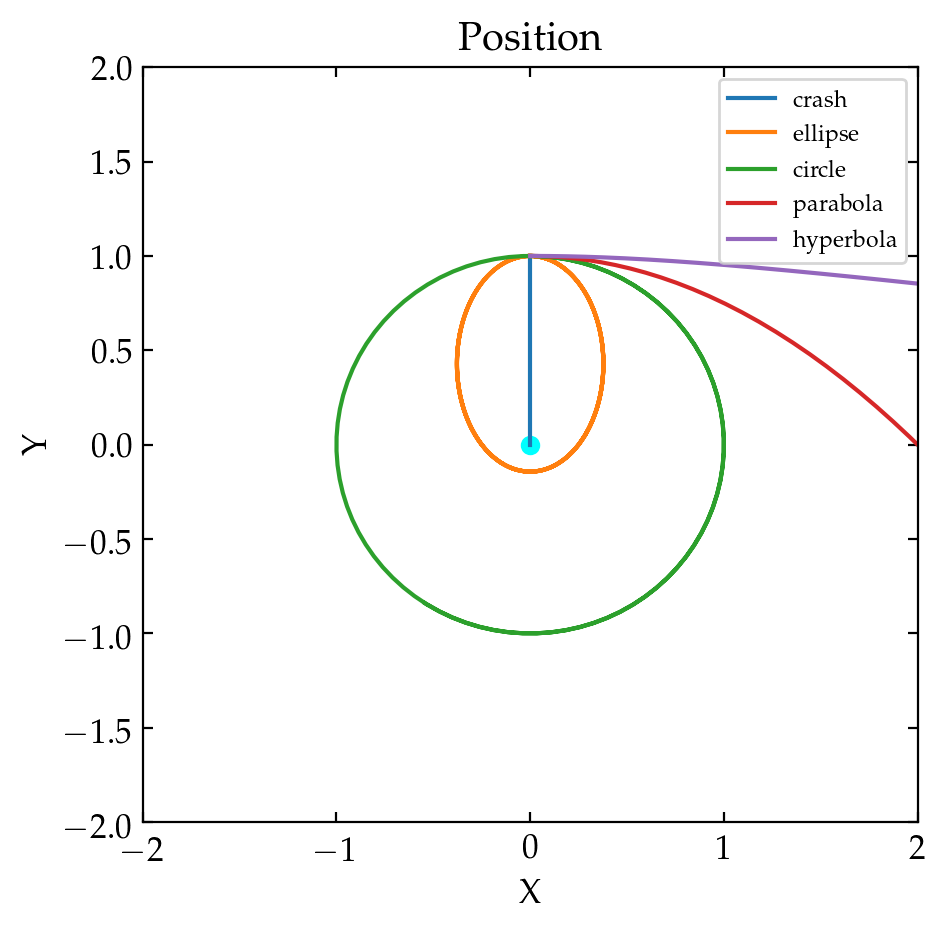

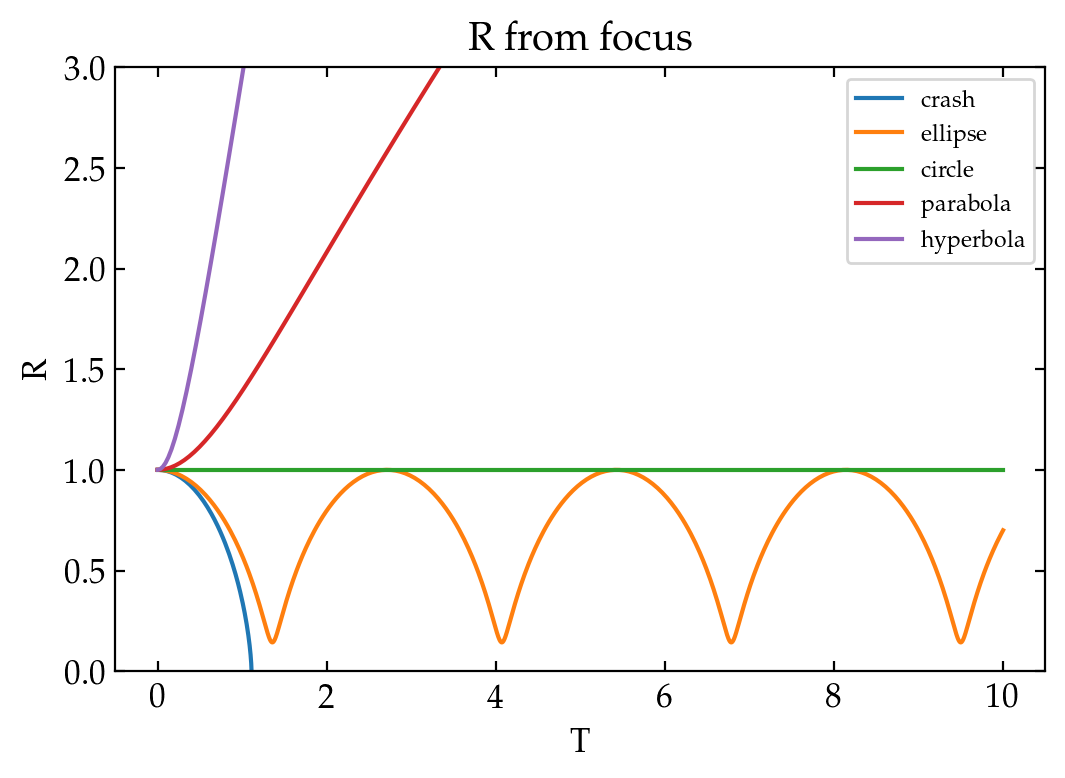

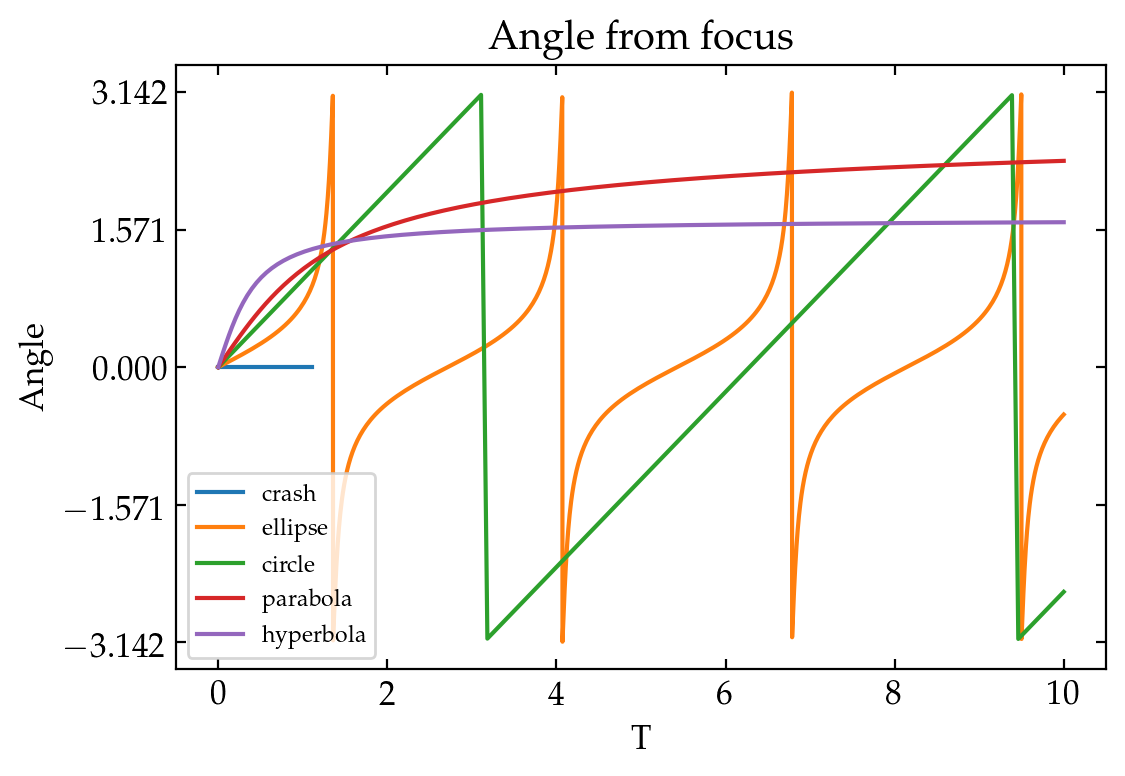

In [4]:
def evolve(t, x):
    return [
        x[2], 
        x[3], 
        -x[0] / (x[0]**2 + x[1]**2)**(3/2),
        -x[1] / (x[0]**2 + x[1]**2)**(3/2),
    ]

# Terminate if we crash into the central point
def crash(t, x):
    r = np.linalg.norm(x[:2])
    return r if r > 1e-7 else 0
crash.terminal = True

                     
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter([0], [0], color="cyan")

_, rax = plt.subplots()
_, fax = plt.subplots()

for (initial_vx, label) in [
    (0, "crash"),
    (0.5, "ellipse"),
    (1, "circle"),
    (np.sqrt(2), "parabola"),
    (3, "hyperbola"),
]:
    initial_conditions = [0, 1, initial_vx, 0] # x, y, vx, vy
    t_init, t_end = 0, 10

    res = scipy.integrate.solve_ivp(evolve, (t_init, t_end), initial_conditions, rtol=1e-9, atol=1e-9, events=crash)
    assert res.success

    ax.plot(res.y[0], res.y[1], label=label)
    rax.plot(res.t, np.sqrt(res.y[0]**2 + res.y[1]**2), label=label)
    fax.plot(res.t, np.arctan2(res.y[0], res.y[1]), label=label)

ax.set(xlim=(-2, 2), ylim=(-2, 2), title="Position", xlabel="X", ylabel="Y")
rax.set(ylim=(0, 3), title="R from focus", xlabel="T", ylabel="R")
fax.set(yticks=np.linspace(-np.pi, np.pi, 5), title="Angle from focus", xlabel="T", ylabel="Angle")

ax.legend(fontsize="x-small")
rax.legend(fontsize="x-small")
fax.legend(fontsize="x-small")

# Q2

I spent an embarrasingly long amount of time worrying that my guiding center point wasn't quite at the same place as the actual point. Especially at high eccentricity!

Approximation... It's in the name...

In [46]:
def get_period(a, mu):
    return np.sqrt(4 * np.pi**2 * a**3 / mu)

def get_a_from_peri(r_peri, e):
    return r_peri / (1 - e)

def get_v_apo(a, e, mu):
    # e = sqrt(1 - h^2 / mu * a), h = r cross r dot = r*r_dot at apo/peri
    # sqrt(mu * a * (1 - e^2)) / r_apo = v_apo
    return np.sqrt(mu * e * (1 - e**2)) / (a + a*e)

def get_v_peri(a, e, mu):
    return np.sqrt(mu * a * (1 - e**2)) / (a - a*e)

r_peri = 1
e = 0.2
mu = 1

a = get_a_from_peri(r_peri, e)
T = get_period(a, mu)
v_peri = get_v_peri(a, e, mu)

print(a, T, v_peri)

1.25 8.781018413800908 1.0954451150103321


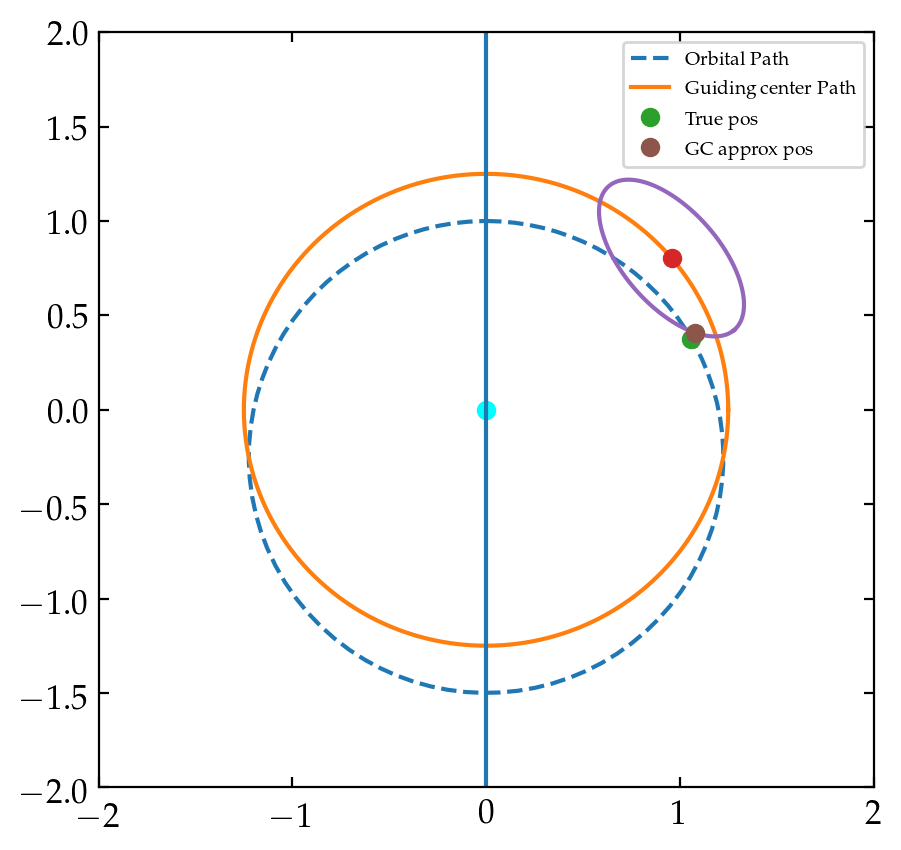

In [143]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(-2, 2), ylim=(-2, 2))

# The focus
ax.scatter([0], [0], color="cyan")

    
# The orbital path
current_pos = [0, r_peri, v_peri, 0]
res = scipy.integrate.solve_ivp(evolve, (0, T), current_pos, rtol=1e-9, atol=1e-9, events=crash)
ax.plot(res.y[0], res.y[1], ls="--", label="Orbital Path")


# Guiding center circle
theta = np.linspace(0, 2*np.pi, num=1000)
ax.plot(a*np.cos(theta), a*np.sin(theta), label="Guiding center Path")


# Setup the true position "line"
true_pos, = ax.plot([], [], lw=0, marker="o", label="True pos")

# Setup the guiding center "line"
gc_pos, = ax.plot([], [], lw=0, marker="o")

# Setup the guiding center ellipse
gc_ellipse, = ax.plot([], [])

# the GC point
gc_point, = ax.plot([], [], lw=0, marker="o", label="GC approx pos")

# initialization function: plot the thing that we are going to redraw
def init():   
    return (true_pos, gc_pos, gc_ellipse, gc_point)

# animation function. This is called sequentially
def animate(t):
    global current_pos, T, a, e
    
    t_scale = 0.1 # just control how fast the animation is
    # Update the true position
    res = scipy.integrate.solve_ivp(evolve, (0, 1 * t_scale), current_pos, rtol=1e-8, atol=1e-8, events=crash)
    assert res.success  
    current_pos = res.y[:,-1]    
    true_pos.set_data([current_pos[0]], [current_pos[1]])
    
    # Update the gc position
    gc_angle = 2 * np.pi * (t+1) * t_scale / T
    gc_x, gc_y = a*np.sin(gc_angle), a*np.cos(gc_angle)
    gc_pos.set_data([gc_x], [gc_y])
    
    # Update the gc ellipse
    gc_ell, gc_loc = ps.ellipse(
        2*a*e, 
        np.sqrt(3/4), # 2:1 ellipse has this e
        [a*np.sin(gc_angle), a*np.cos(gc_angle)], 
        -gc_angle, # rotates in the other direction
        with_loc = True,
    )
    gc_ellipse.set_data(gc_ell[0], gc_ell[1])
    
    # And the gc point
    gc_point.set_data([gc_loc[0]], [gc_loc[1]])
    return (true_pos, gc_pos)

ax.axvline(0)
ax.legend(fontsize="xx-small")
HTML(animation.FuncAnimation(
        fig, animate, init_func=init, frames=100, interval=100, blit=True,
).to_html5_video())

# Q3

## Impact approx

Not a bad approximation!
This would be better for smaller deviation, worse for larger


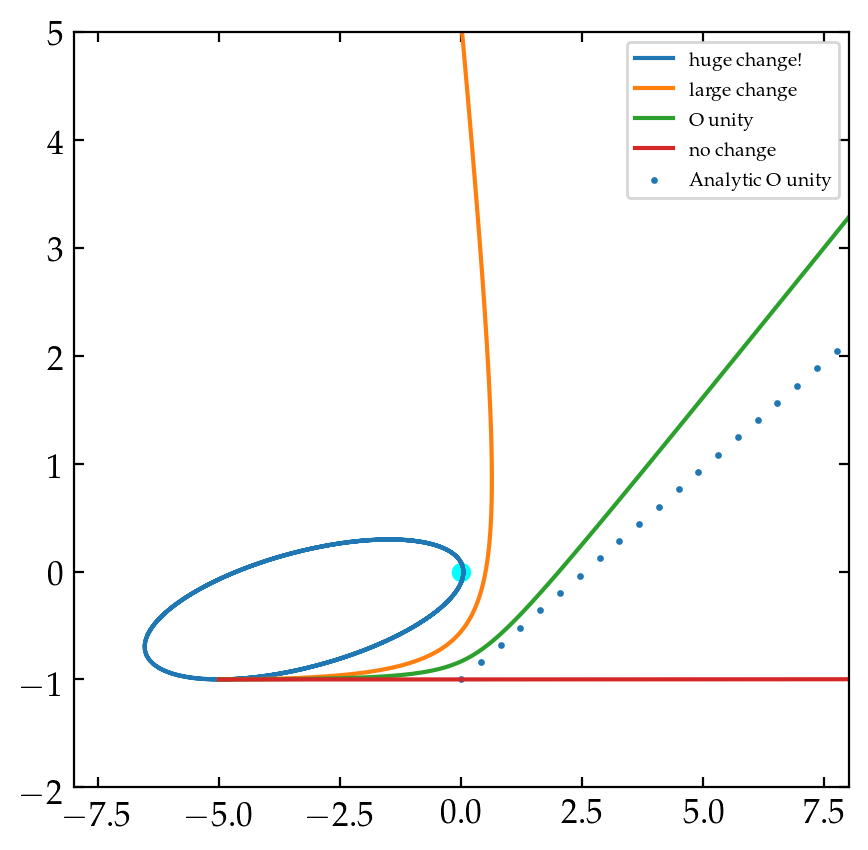

In [5]:
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter([0], [0], color="cyan")
for v_initial, label in [
    (0.3, "huge change!"),
    (1, "large change"),
    (2, "O unity"),
    (100, "no change"),
]:
    initial_conditions = [-5, -1, v_initial, 0] # x, y, vx, vy
    t_init, t_end = 0, 100

    res = scipy.integrate.solve_ivp(evolve, (t_init, t_end), initial_conditions, rtol=1e-9, atol=1e-9, events=crash)
    assert res.success

    ax.plot(res.y[0], res.y[1], label=label)
ax.set(xlim=(-8, 8), ylim=(-2, 5))

# Using the analytic formula - delta V = pi / (2bv)
b = 1
v = 2
delta_v = np.pi / (2 * b * v)

t = np.linspace(0, 10)
v_vec = np.array([[v], [delta_v]])
initial_pos = np.array([[0], [-1]])
pos = initial_pos + t * v_vec
ax.scatter(pos[0], pos[1], s=2, label="Analytic O unity")

ax.legend(fontsize="xx-small")
print("Not a bad approximation!")
print("This would be better for smaller deviation, worse for larger")

## Simulation of star diving towards black hole or comet to sun

This situation is roughly - object with pretty low velocity very far away falls towards high mass thing. While this is an elliptical orbit, it has e ~ 1 and so looks a lot like a parabolic orbit, at least near the object it is going around.

Ok great, that is what the orbit as a whole looks like


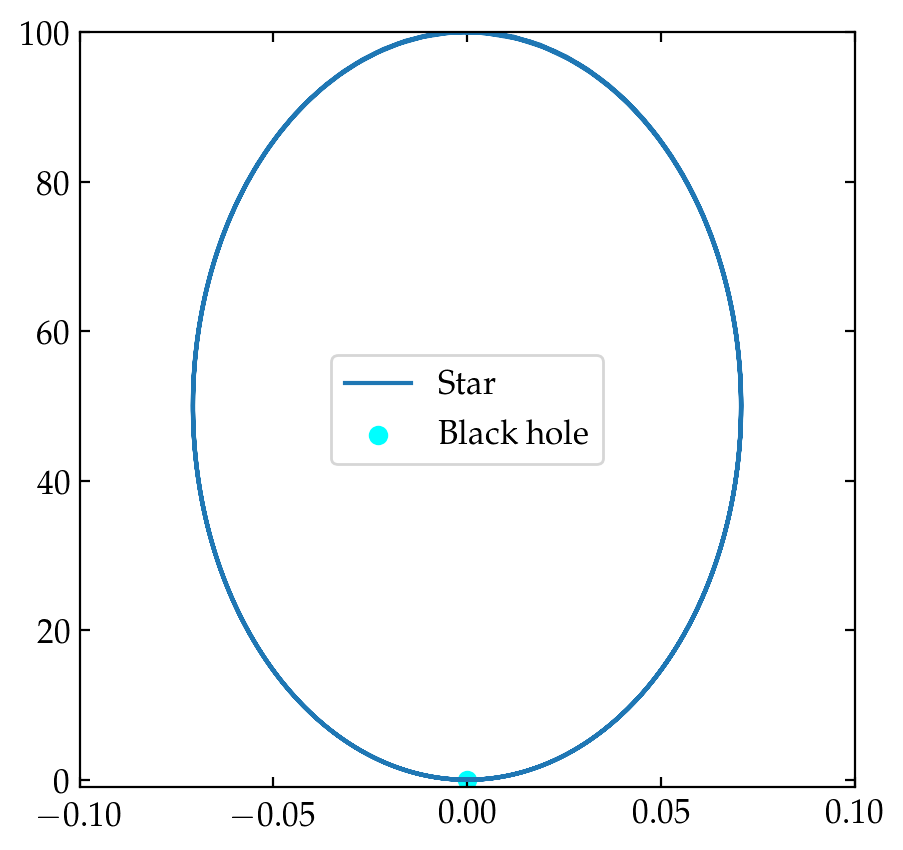

In [132]:
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter([0], [0], color="cyan", label="Black hole")

initial_conditions = [0, 100, 0.0001, 0] # x, y, vx, vy
t_init, t_end = 0, 10000
res = scipy.integrate.solve_ivp(evolve, (t_init, t_end), initial_conditions, rtol=1e-9, atol=1e-9, events=crash)
assert res.success

ax.plot(res.y[0], res.y[1], label="Star")
ax.set(xlim=(-0.1, 0.1), ylim=(-1, 100))
ax.legend()
print("Ok great, that is what the orbit as a whole looks like")

Let's zoom in near the black hole, and also make the aspect ratio a bit less distorted
That fit looks pretty good!


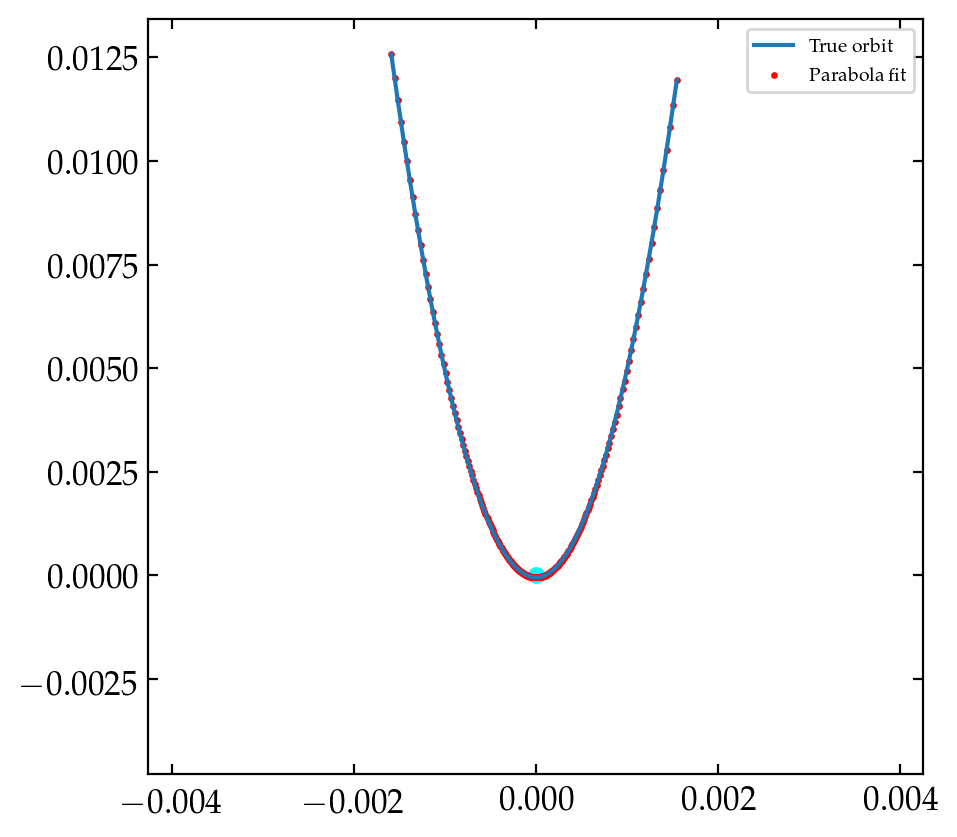

In [130]:
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter([0], [0], color="cyan", linewidth=0.1)

cx = res.y[0][820:1100]
cy = res.y[1][820:1100]
ax.plot(cx, cy, label="True orbit")

def parabola(x, a, b, c):
    return a + b*x + c*x**2

popt, _ = scipy.optimize.curve_fit(parabola, cx, cy)
ax.scatter(cx, parabola(cx, *popt), s=2, c="r", label="Parabola fit")
ax.legend(fontsize="xx-small")
print("Let's zoom in near the black hole, and also make the aspect ratio a bit less distorted")
print("That fit looks pretty good!")

## Peturbations

If we give the kick at the apocenter:
Small kick along the orbit (small +vx) reduces e, increases a, increases r at peri and keeps r at apo
Small kick away from the focus (small +vy) makes it slower to turn, precessing the orbit
Large kick in the opposite direction of v (large -vx) does the opposive of the +vx kick
Having both an along-the-orbit and perpendicular-to-the-orbit components, combine as expected from individual actions



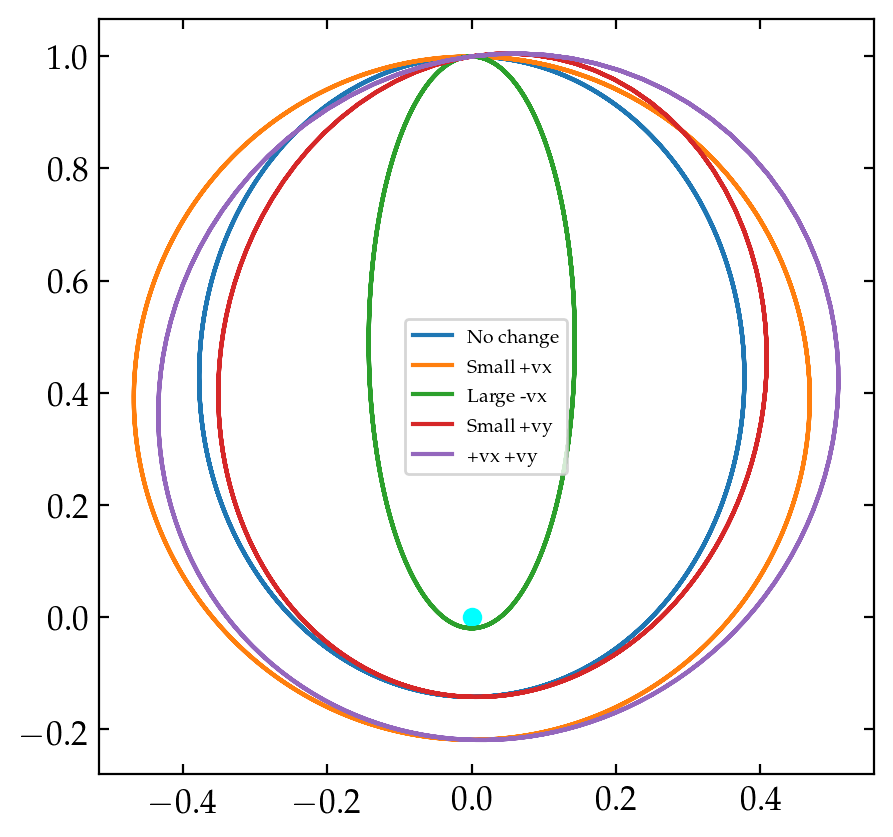

In [145]:
_, ax = plt.subplots(figsize=(5, 5))
ax.scatter([0], [0], color="cyan")


for (peturb_vx, peturb_vy, label) in [
    (0, 0, "No change"),
    (0.1, 0, "Small +vx"),
    (-0.3, 0, "Large -vx"),
    (0, 0.1, "Small +vy"),
    (0.1, 0.1, "+vx +vy"),
]:
    initial_conditions = [0, 1, 0.5 + peturb_vx, 0 + peturb_vy] # x, y, vx, vy
    t_init, t_end = 0, 10

    res = scipy.integrate.solve_ivp(evolve, (t_init, t_end), initial_conditions, rtol=1e-9, atol=1e-9, events=crash)
    assert res.success

    ax.plot(res.y[0], res.y[1], label=label)
ax.legend(fontsize="xx-small")

print("""If we give the kick at the apocenter:
Small kick along the orbit (small +vx) reduces e, increases a, increases r at peri and keeps r at apo
Small kick away from the focus (small +vy) makes it slower to turn, precessing the orbit
Large kick in the opposite direction of v (large -vx) does the opposive of the +vx kick
Having both an along-the-orbit and perpendicular-to-the-orbit components, combine as expected from individual actions
""")